In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_log_error
from tensorflow.keras.models import load_model

2025-04-19 10:28:58.084837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745033338.101955 2571354 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745033338.107236 2571354 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745033338.120387 2571354 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745033338.120410 2571354 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745033338.120412 2571354 computation_placer.cc:177] computation placer alr

In [2]:
df = pd.read_csv(r'/home/long/longdata/kaggle compe/dataset/num_df.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   pickup_longitude   1458644 non-null  float64
 1   pickup_latitude    1458644 non-null  float64
 2   dropoff_longitude  1458644 non-null  float64
 3   dropoff_latitude   1458644 non-null  float64
 4   trip_duration      1458644 non-null  int64  
 5   haversine_km       1458644 non-null  float64
 6   bearing            1458644 non-null  float64
 7   is_zero_distance   1458644 non-null  bool   
 8   pickup_cluster     1458644 non-null  int64  
 9   dropoff_cluster    1458644 non-null  int64  
dtypes: bool(1), float64(6), int64(3)
memory usage: 101.5 MB


In [3]:
x = df.drop('trip_duration', axis=1)
y = df['trip_duration']
print(x.columns)

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'haversine_km', 'bearing', 'is_zero_distance',
       'pickup_cluster', 'dropoff_cluster'],
      dtype='object')


In [4]:
df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,haversine_km,bearing,is_zero_distance,pickup_cluster,dropoff_cluster
0,-73.982155,40.767937,-73.964630,40.765602,455,1.498521,99.970196,False,0,8
1,-73.980415,40.738564,-73.999481,40.731152,663,1.805507,242.846232,False,0,9
2,-73.979027,40.763939,-74.005333,40.710087,2124,6.385098,200.319835,False,0,9
3,-74.010040,40.719971,-74.012268,40.706718,429,1.485498,187.262300,False,4,9
4,-73.973053,40.793209,-73.972923,40.782520,435,1.188588,179.473585,False,3,8


In [5]:
def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.clip_by_value(y_true, 1e-7, tf.reduce_max(y_true))
    y_pred = tf.clip_by_value(y_pred, 1e-7, tf.reduce_max(y_pred))
    log_true = tf.math.log(y_true + 1.0)
    log_pred = tf.math.log(y_pred + 1.0)
    return tf.sqrt(tf.reduce_mean(tf.square(log_pred - log_true)))

In [6]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [ ]:
model = keras.Sequential([
    layers.Input(shape=(x_scaled.shape[1],)),
    
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=rmsle,
    metrics=[rmsle]
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

I0000 00:00:1745033342.844683 2571354 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1243 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:02:00.0, compute capability: 8.6


In [8]:
history = model.fit(
    x_scaled, y,
    validation_split=0.01,
    epochs=100,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100


I0000 00:00:1745033345.033870 2571590 service.cc:152] XLA service 0x7f5a2000cdb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745033345.033893 2571590 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-04-19 10:29:05.106368: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745033345.349813 2571590 cuda_dnn.cc:529] Loaded cuDNN version 90300


  28/5641 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 5.8388 - rmsle: 5.8388 

I0000 00:00:1745033346.216835 2571590 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5641/5641 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 1.1004 - rmsle: 1.1004 - val_loss: 0.5228 - val_rmsle: 0.5228
Epoch 2/100
5641/5641 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.4685 - rmsle: 0.4685 - val_loss: 0.4937 - val_rmsle: 0.4936
Epoch 3/100
5641/5641 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.4615 - rmsle: 0.4615 - val_loss: 0.5227 - val_rmsle: 0.5227
Epoch 4/100
5641/5641 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.4582 - rmsle: 0.4582 - val_loss: 0.4500 - val_rmsle: 0.4499
Epoch 5/100
5641/5641 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.4579 - rmsle: 0.4579 - val_loss: 0.4515 - val_rmsle: 0.4515
Epoch 6/100
5641/5641 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.4546 - rmsle: 0.4546 - val_loss: 0.4505 - val_rmsle: 0.4505
Epoch 7/100
5641/5641 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.4530 - rmsle: 0.4530 - val_loss: 0.4505 - val_rmsle: 0.4505
Epoch 8/100
5641/5641 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.4531 - rmsle: 0.4531 - val_loss: 0.4615 - val_rmsle: 0.4615
Epoc

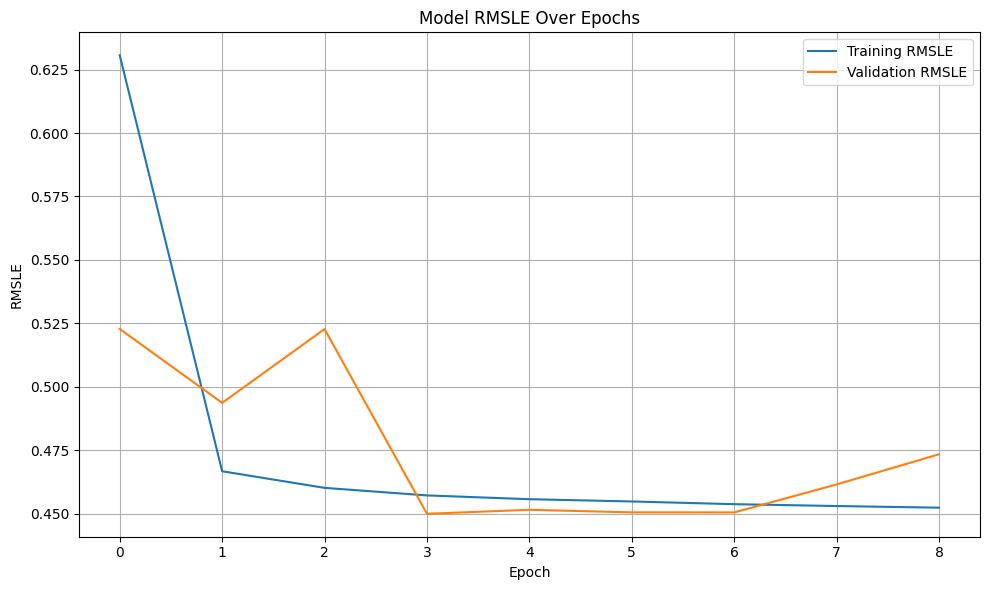

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training RMSLE')
plt.plot(history.history['val_loss'], label='Validation RMSLE')
plt.title('Model RMSLE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSLE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
model.save('nn2.keras')

In [11]:
test_df = pd.read_csv(r'/home/long/longdata/kaggle compe/dataset/test.csv')
df = pd.read_csv(r'/home/long/longdata/kaggle compe/dataset/num_df.csv')
scaler = StandardScaler()
test_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [12]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371 
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

def bearing(lat1, lon1, lat2, lon2):
    dLon = np.radians(lon2 - lon1)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    x = np.sin(dLon) * np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees(np.arctan2(x, y)) + 360) % 360

test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'])
test_df['haversine_km'] = haversine(test_df['pickup_latitude'], test_df['pickup_longitude'],
                                    test_df['dropoff_latitude'], test_df['dropoff_longitude'])
test_df['bearing'] = bearing(test_df['pickup_latitude'], test_df['pickup_longitude'],
                             test_df['dropoff_latitude'], test_df['dropoff_longitude'])
test_df['is_zero_distance'] = test_df['haversine_km'] < 0.01
pickup_coords = df[['pickup_latitude', 'pickup_longitude']].dropna()
dropoff_coords = df[['dropoff_latitude', 'dropoff_longitude']].dropna()

pickup_kmeans = KMeans(n_clusters=10, random_state=42).fit(pickup_coords)
dropoff_kmeans = KMeans(n_clusters=10, random_state=42).fit(dropoff_coords)

test_df['pickup_cluster'] = pickup_kmeans.predict(test_df[['pickup_latitude', 'pickup_longitude']])
test_df['dropoff_cluster'] = dropoff_kmeans.predict(test_df[['dropoff_latitude', 'dropoff_longitude']])

In [13]:
test_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,haversine_km,bearing,is_zero_distance,pickup_cluster,dropoff_cluster
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,2.746426,356.404776,False,4,0
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,2.759239,172.278835,False,4,5
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,1.306155,133.326248,False,4,9
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,5.269088,209.043167,False,3,9
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,0.960842,130.260381,False,0,0


In [16]:
features = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'haversine_km', 'bearing', 'pickup_cluster', 'dropoff_cluster', 'is_zero_distance']
scaler = StandardScaler()
scaler.fit(df[features])  

x_test_scaled = scaler.transform(test_df[features])  
def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.clip_by_value(y_true, 1e-7, tf.reduce_max(y_true))
    y_pred = tf.clip_by_value(y_pred, 1e-7, tf.reduce_max(y_pred))
    log_true = tf.math.log(y_true + 1.0)
    log_pred = tf.math.log(y_pred + 1.0)
    return tf.sqrt(tf.reduce_mean(tf.square(log_pred - log_true)))

model = load_model(
    r'/home/long/longdata/kaggle compe/nyc-taxi-trip-duration/nn2.keras',
    custom_objects={'rmsle': rmsle}
)
y_pred = model.predict(x_test_scaled)

test_predictions = pd.DataFrame({'trip_duration': y_pred.flatten()})
test_predictions.to_csv('test_pred.csv', index=False)

19536/19536 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step
